<a href="https://colab.research.google.com/github/epsilon-deltta/amazon-review/blob/master/boostFeature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import  

In [1]:
!pip install livelossplot
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten  

from keras.layers import Conv2D,MaxPooling1D,MaxPooling2D ,Conv1D

from keras.layers import Dropout , BatchNormalization
from keras.layers import Embedding , LSTM

from keras.callbacks import ModelCheckpoint,EarlyStopping
!pip install livelossplot
from livelossplot import PlotLossesKeras

#### Do once (load , nlp preprocess , build Embedding Matrix ) 

# in colab
# preprocess
# embedding
# xtr,ytr,xte,yte, embedding_matrix,vocab_size,vector_size = load_data(path)

### handle data 

In [2]:
if not os.path.exists('data'):
    os.system('git clone https://github.com/epsilon-deltta/dataset data')
    path = './data/amazon-review/'
else :
    if os.path.exists('data/amazon-review'):
        path = './data/amazon-review/'
    else:
        path = './data/'
def load_data(path='./data/'):
    testdir  = path + 'test/'
    traindir = path + 'train/'

    df = [ pd.DataFrame(columns = ['n','review','target']) for _ in range(2)]

    for i,path in enumerate([traindir,testdir]):
        path = path
        label = 'positive'

        poslist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

        label = 'negative' 
        neglist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

        sep = os.path.sep

        for fpath in poslist :
            num = fpath.split(sep)[-1]
            with open(fpath,'r') as f :
                content = f.read()

            item = dict(zip(df[i].columns,[num,content,1] ) )
            df[i] = df[i].append(item,ignore_index=True)

        for fpath in neglist :
            num = fpath.split(sep)[-1]
            with open(fpath,'r') as f :
                content = f.read()

            item = dict(zip(df[i].columns,[num,content,0] ) )
            df[i] = df[i].append(item,ignore_index=True)
    return df[0].review,df[0].target,df[1].review,df[1].target

xtr,ytr,xte,yte = load_data(path)

In [3]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence,Tokenizer
from keras.preprocessing import text

# - Word Index: keep the most frequent 10k words
vocab_size = 10000
token = Tokenizer(num_words = vocab_size + 1) # 상위 10000개 단어만 사용

token.fit_on_texts(xtr)
max_len = 400
def preprocess(docs,token,max_len=400):
    docs = token.texts_to_sequences(docs)
    
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    docs = pad_sequences(docs, maxlen=max_len)
    
    return docs

xtr = preprocess(xtr,token)
xte = preprocess(xte,token)

In [4]:
# - Word embedding dimension: 100
# vocab_size  = token.num_words # 10000+ 1 
vector_size = 100  #100
vocab_size = 10001

def get_emb_mtr():
    wv = pd.read_csv(path+'all.review.vec.txt',sep=' ',skiprows=1,header=None)

    wv.set_index(0,inplace=True)
    del wv[101]


    embedding_matrix = np.zeros((vocab_size, vector_size))

    def get_vector(word):
        if word in wv.index:
            return wv.loc[word]
        else:
            return None

    num = 0
    word_index = [( i,word) for i,word in token.index_word.items()][:10000]
    not_used = []
    for i,word in word_index: 
        temp = get_vector(word)
        if temp is not None: 

            embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
        else :
            not_used.append(word)
            num+=1
    return embedding_matrix , not_used,num,wv

embedding_matrix , not_used,num,wv = get_emb_mtr()

#### preprocess(cleaning) 
'solar > ' solar # 대부분의 단어가 'solar queen ' 여거에서 파생됨 , 'solar queen ' 책 제목이나 영화이름을 지칭한듯 보인다.
laszlo : 이름   
battelle : 사람이름   
zia : 장소이름    
huband : 사람이름  
arnhart : 사람이름  
groothuis : 사람이름  
eddison : 사람이름

3rds > thirds

In [5]:
xtr = xtr.astype('float')
xte = xte.astype('float')
ytr = ytr.astype('float')
yte = yte.astype('float')

In [14]:
from sklearn.model_selection import train_test_split
x = np.concatenate([xtr,xte])
y = np.concatenate([ytr,yte])
xtr, xte, ytr, yte   = train_test_split(x, y, test_size=0.3, random_state=10)
    # xtr, xval, ytr, yval = train_test_split(xtr, ytr, test_size=trval_rate, random_state=10) 

### model 

In [31]:
def get_bestpath(pathname):
    import re
    modelf = re.compile('\d+[-]')
    bestpath = sorted([ fname for fname in os.listdir(pathname) if modelf.match(fname) ],reverse=True)[0]
    bestpath = pathname+'/'+bestpath
    return bestpath

def livetrain(model):
    
    dirname = model.name
    if os.path.exists(dirname):
        for name in os.listdir(dirname):
            os.remove(dirname+'/'+name)
    else :
        os.mkdir(dirname)
    modelpath= dirname + "/{epoch:02d}-{val_loss:.4f}-{val_acc:f}.hdf5"

    live  = PlotLossesKeras()
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_acc', verbose=1,patience=20,save_best_only=True)    
    
    history = model.fit(xtr, ytr, batch_size=200, epochs=300, verbose=1
                    # ,validation_data=(xval, yval) \
                    ,validation_split=0.2
                    ,callbacks=[live,early,checkpointer])
    
    bestpath = get_bestpath(dirname)
    model.load_weights(bestpath)
        
    print(bestpath)
    print(model.evaluate(xte,yte) )

In [32]:
model_name = 'lstmb2'
gpus = tf.config.experimental.list_logical_devices('gpu')
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

with strategy.scope():

    model = Sequential(name = model_name)
    e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
    model.add(e)
    model.add(LSTM(100,activation='tanh'))
    model.add(BatchNormalization())
    
    model.add(Dense(100,kernel_regularizer=tf.keras.regularizers.l2(0.001) ) )
    
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())
    
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

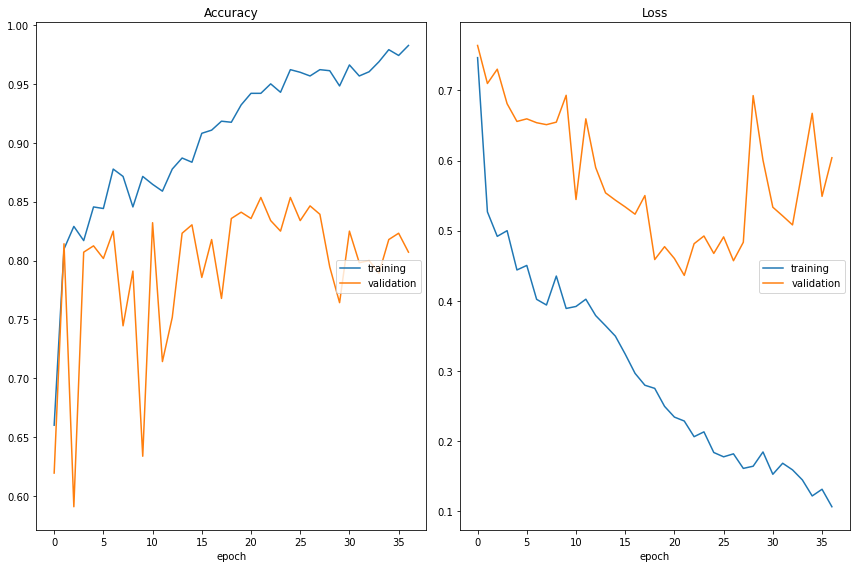

Accuracy
	training         	 (min:    0.660, max:    0.983, cur:    0.983)
	validation       	 (min:    0.591, max:    0.854, cur:    0.807)
Loss
	training         	 (min:    0.106, max:    0.747, cur:    0.106)
	validation       	 (min:    0.436, max:    0.764, cur:    0.604)

Epoch 00037: val_acc did not improve from 0.85357
lstmb2/22-0.4362-0.853571.hdf5
38/38 [==============================] - 0s 12ms/step - loss: 0.4108 - acc: 0.8533
[0.41083431243896484, 0.8533333539962769]


In [33]:
livetrain(model)